In [176]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from hembedder.utils import distance, hyperparameter_tuning, quality_metrics


import umap
import phate
import ivis
import pacmap

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS

import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.chdir('T:/laupodteam/AIOS/Bram/data')

# Load data

This is imputed CELLDYN with combined variables.

In [3]:
celldyn_raw = pd.read_feather("./CellDyn/celldyn.feather")
celldyn_raw.columns = celldyn_raw.columns.str.lower()
fail_columns = [c for c in celldyn_raw.columns if 'fail' in c]
celldyn_raw = celldyn_raw.query('c_b_ht>0.2 and c_b_hb>0.2 and c_b_rbco>0.1 and c_b_rbco<100 and c_b_hb<20')
meas_columns_raw = [c for c in celldyn_raw.columns if 'c_b' in c]+['plt']
celldyn_raw['fcs_id'] = celldyn_raw['fcs_id'].str.decode('utf-8')

In [4]:
celldyn_full = pd.read_feather("L:/laupodteam/AIOS/Bram/data/CellDyn/artifacts/celldyn_FULL_transformed_df.feather")
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c or 'COMBO_' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
demo_columns = ['gender', 'age']

In [5]:
celldyn_full_updated = pd.read_feather("./CellDyn/artifacts/celldyn_FULL_transformed_df_updated.feather")
replace_combos = {c: "COMBO_"+c for c in ['SII', 'NHL', 'NLR', 'PLR', 'HLR', 'LMR', 'WRR', 
                             'NWR', 'WPR', 'PRR', 'RHR', 'RIR', 'HHR',  'LSR',
                              'PMR', 'LPR', 'MHR', 'MMR']}
celldyn_full_updated = celldyn_full_updated.rename(columns=replace_combos)
meas_columns_update = [c for c in celldyn_full_updated.columns if 'c_b' in c or 'COMBO_' in c]

In [6]:
meta = pd.read_parquet("./CellDyn/artifacts/celldyn_labels.parquet")
meta = meta[~meta.dataset.isnull()]
meta = meta.rename(columns={'studyId_Alle_celldyn': 'studyid_alle_celldyn'})

In [7]:
meta = meta.assign(INFLAM=meta['dataset'].str.contains('MDL|REUMA'))
meta = meta.assign(HEART=meta['dataset'].str.contains('ARGUS|UCORBIO|HEARTSCORE'))
meta = meta.assign(BLOOD=meta['dataset'].str.contains('MDS|CLL'))
CCOLS=['INFLAM', 'HEART', 'BLOOD']

In [8]:
# append celldyn indices
celldyn_raw = celldyn_raw.merge(meta[['fcs_id', 'dataset']+CCOLS], on='fcs_id', how='left')
celldyn_full = celldyn_full.merge(meta[['studyid_alle_celldyn', 'afname_dt', 'dataset']+CCOLS],
                                   on=['studyid_alle_celldyn', 'afname_dt'], how='left')
celldyn_full_updated = celldyn_full_updated.merge(meta[['studyid_alle_celldyn', 'afname_dt', 'dataset']+CCOLS],
                                   on=['studyid_alle_celldyn', 'afname_dt'], how='left')

## Reduce dimensions

In [254]:
SAMPLE_SIZE = 250
embedder_type = 'pacmap'

# CNN13 network as AE for SSL

if embedder_type == 'umap':
    kwargs =   {'n_neighbors': 100, 
                'min_dist': 0., 
                'n_components': 2, 
                'random_state': 42, 
                'n_epochs': 200,
                'metric': 'canberra', # canberra, manhattan
                'output_metric': 'euclidean', 
                'init': 'random',
                'learning_rate': 0.9,
                'repulsion_strength': 1.1,
                'negative_sample_rate': 20,
                'densmap': True,
                'verbose': True}
    kwarg_string = '_'.join([f'{k}_{v}' for k,v in kwargs.items()])

    embedder_raw = umap.UMAP(**kwargs)
    embedder_full = umap.UMAP(**kwargs)
    embedder_full_update = umap.UMAP(**kwargs)
elif embedder_type == 'phate':
    embedder_raw = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=2, random_state=42)
    embedder_full = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=2, random_state=42)
    embedder_full_update = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=2, random_state=42)
elif embedder_type == 'ivis':
    embedder_raw = ivis.Ivis(k=50, n_epochs_without_progress=100, n_components=2, random_state=42)
elif embedder_type == 'pacmap':
    kwargs = {'n_dims':2, 
              'distance':"manhattan",
              'apply_pca':True, 
              'n_neighbors':100, 
              'lr':0.025, 
              'num_iters':1000, 
              'MN_ratio':0.5, 
              'FP_ratio':2, 
              'verbose':True}
    
    embedder_raw = pacmap.PaCMAP(**kwargs)
    embedder_full = pacmap.PaCMAP(**kwargs)
    embedder_full_update = pacmap.PaCMAP(**kwargs)
    
#print(kwargs)
gc.collect()

32799

In [255]:
sample_ids = celldyn_full.sample(SAMPLE_SIZE).studyid_alle_celldyn.unique()
sample_index_raw = celldyn_raw[celldyn_raw.studyid_alle_celldyn.isin(sample_ids)].dropna(subset=meas_columns_raw).index
sample_index_full = celldyn_full[celldyn_full.studyid_alle_celldyn.isin(sample_ids)].index
sample_index_full_update = celldyn_full_updated[celldyn_full_updated.studyid_alle_celldyn.isin(sample_ids)].index

print(sample_index_raw.shape, sample_index_full.shape, sample_index_full_update.shape)

(9538,) (16377,) (16235,)


In [256]:
print("Fitting on RAW data")
#embedder_raw.fit(celldyn_raw.loc[sample_index_raw, meas_columns_raw].values)
embedded_raw = embedder_raw.fit_transform(celldyn_raw.loc[sample_index_raw, meas_columns_raw].values)
print("Fitting on FULL data")
embedded_full = embedder_full.fit_transform(celldyn_full.loc[sample_index_full, meas_columns].values)
print("Fitting on FULL data (updated)")
embedded_full_update = embedder_full_update.fit_transform(celldyn_full_updated.loc[sample_index_full_update, meas_columns_update].values)
print("Fitting PCA on FULL data (updated)")
embeddedPCA_full_update = PCA(n_components=2).fit_transform(celldyn_full_updated.loc[sample_index_full_update, meas_columns_update].values)
gc.collect()

Fitting on RAW data
PaCMAP(n_neighbors=100, n_MN=50, n_FP=200, distance=manhattan, lr=0.025, n_iters=1000, apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
X is normalized
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
Initial Loss: 1175869.375
Iteration:   10, Loss: 1107364.875000
Iteration:   20, Loss: 968872.687500
Iteration:   30, Loss: 868990.375000
Iteration:   40, Loss: 804117.875000
Iteration:   50, Loss: 752544.000000
Iteration:   60, Loss: 708676.625000
Iteration:   70, Loss: 667522.125000
Iteration:   80, Loss: 626190.125000
Iteration:   90, Loss: 584717.437500
Iteration:  100, Loss: 541243.625000
Iteration:  110, Loss: 633399.125000
Iteration:  120, Loss: 618163.000000
Iteration:  130, Loss: 605151.687500
Iteration:  140, Loss: 594006.500000
Iteration:  150, Loss: 584371.625000
Iteration:  160, Loss: 575916.500000
Iteration:  170, Loss: 568411.125000
Iteration:  180, Loss: 561755.375000
Iter

In [ ]:
sample_index_raw = celldyn_raw[celldyn_raw.studyid_alle_celldyn.isin(sample_ids)].dropna(subset=meas_columns_raw).index
sample_index_full = celldyn_full[celldyn_full.studyid_alle_celldyn.isin(sample_ids)].index
sample_index_full_update = celldyn_full_updated[celldyn_full_updated.studyid_alle_celldyn.isin(sample_ids)].index

In [ ]:
embedded_raw_df = pd.DataFrame(embedded_raw, columns=['UMAP1', 'UMAP2'], index=sample_index_raw)
embedded_full_df = pd.DataFrame(embedded_full, columns=['UMAP1', 'UMAP2'], index=sample_index_full)
embedded_full_update_df = pd.DataFrame(embedded_full_update, columns=['UMAP1', 'UMAP2'], index=sample_index_full_update)
embeddedPCA_full_update_df = pd.DataFrame(embeddedPCA_full_update, columns=['PCA1', 'PCA2'], index=sample_index_full_update)

In [ ]:
# add age/sex
embedded_raw_df = embedded_raw_df.join(celldyn_raw.loc[sample_index_raw,
                                                        ['age', 'gender', 'dataset', 'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embedded_full_df = embedded_full_df.join(celldyn_full.loc[sample_index_full, 
                                                        ['age', 'gender', 'dataset', 'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embedded_full_update_df = embedded_full_update_df.join(celldyn_full_updated.loc[sample_index_full_update, 
                                                        ['age', 'gender', 'dataset',  'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embeddedPCA_full_update_df = embeddedPCA_full_update_df.join(celldyn_full_updated.loc[sample_index_full_update, 
                                                        ['age', 'gender', 'dataset',  'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])

In [ ]:
embedded_raw_df = embedded_raw_df.assign(draw_hour = embedded_raw_df.afname_dt.dt.hour)
embedded_full_df = embedded_full_df.assign(draw_hour = embedded_full_df.afname_dt.dt.hour)
embedded_full_update_df = embedded_full_update_df.assign(draw_hour = embedded_full_update_df.afname_dt.dt.hour)
embeddedPCA_full_update_df = embeddedPCA_full_update_df.assign(draw_hour = embeddedPCA_full_update_df.afname_dt.dt.hour)

(-13.908382529994947, 17.86728816939141)

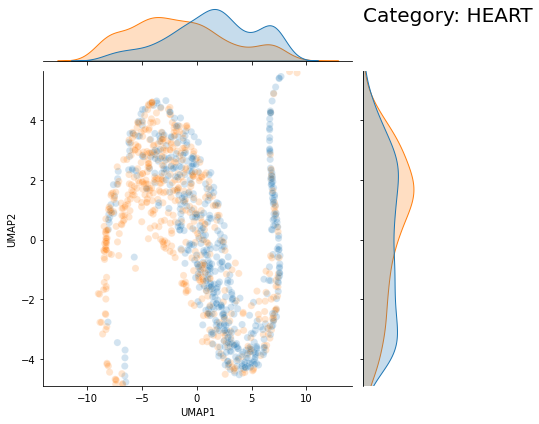

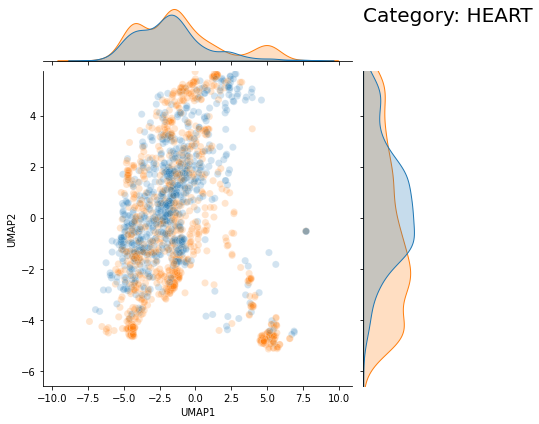

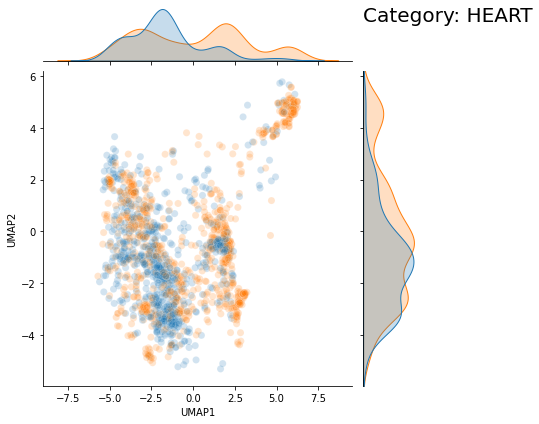

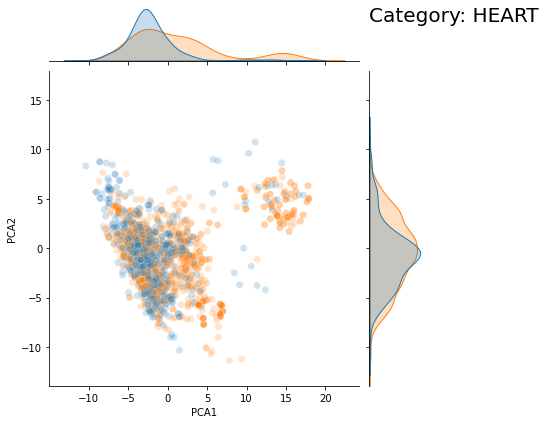

In [ ]:
CAT =  'HEART' # 'INFLAM' # BLOOD, INFLAM, HEART, draw_hour
PALETTE = None # "Spectral"
alpha = 0.2
csize = 50
kind = 'scatter'

q=0.001

q1_05 = embedded_raw_df.UMAP1.quantile(q)
q1_95 = embedded_raw_df.UMAP1.quantile(1-q)
q2_05 = embedded_raw_df.UMAP2.quantile(q)
q2_95 = embedded_raw_df.UMAP2.quantile(1-q)
# generate subplots, 3 cols
sns.jointplot(data=embedded_raw_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
              x='UMAP1', y='UMAP2', hue=CAT,
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)

q1_05 = embedded_full_df.UMAP1.quantile(q)
q1_95 = embedded_full_df.UMAP1.quantile(1-q)
q2_05 = embedded_full_df.UMAP2.quantile(q)
q2_95 = embedded_full_df.UMAP2.quantile(1-q)
sns.jointplot(data=embedded_full_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
                x='UMAP1', y='UMAP2', hue=CAT,
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)

q1_05 = embedded_full_update_df.UMAP1.quantile(q)
q1_95 = embedded_full_update_df.UMAP1.quantile(1-q)
q2_05 = embedded_full_update_df.UMAP2.quantile(q)
q2_95 = embedded_full_update_df.UMAP2.quantile(1-q)
sns.jointplot(data=embedded_full_update_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"),
                x='UMAP1', y='UMAP2', hue=CAT,
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)

q1_05 = embeddedPCA_full_update_df.PCA1.quantile(q)
q1_95 = embeddedPCA_full_update_df.PCA1.quantile(1-q)
q2_05 = embeddedPCA_full_update_df.PCA2.quantile(q)
q2_95 = embeddedPCA_full_update_df.PCA2.quantile(1-q)
sns.jointplot(data=embeddedPCA_full_update_df.dropna(subset=[CAT]).query(f"PCA1>{q1_05} & PCA1<{q1_95} \
                                                              & PCA2>{q1_05} & PCA2<{q1_95}"),
                x='PCA1', y='PCA2', hue=CAT, 
                alpha=alpha, palette=PALETTE, legend=False, s=csize, kind=kind)
plt.title(f"Category: {CAT}", fontsize=20, loc='left', pad=50)
#plt.xlim(q1_05, q1_95)
plt.ylim(q2_05, q2_95)